# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3743744/11490434 [========>.....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:04 - loss: 0.6945

  27/1875 [..............................] - ETA: 3s - loss: 0.5574   

  53/1875 [..............................] - ETA: 3s - loss: 0.4781

  85/1875 [>.............................] - ETA: 3s - loss: 0.4278

 115/1875 [>.............................] - ETA: 3s - loss: 0.3989

 141/1875 [=>............................] - ETA: 3s - loss: 0.3809

 167/1875 [=>............................] - ETA: 3s - loss: 0.3666

 193/1875 [==>...........................] - ETA: 3s - loss: 0.3547

 217/1875 [==>...........................] - ETA: 3s - loss: 0.3454

 244/1875 [==>...........................] - ETA: 3s - loss: 0.3362

 277/1875 [===>..........................] - ETA: 2s - loss: 0.3265

 311/1875 [===>..........................] - ETA: 2s - loss: 0.3177

 345/1875 [====>.........................] - ETA: 2s - loss: 0.3101

 378/1875 [=====>........................] - ETA: 2s - loss: 0.3034

 401/1875 [=====>........................] - ETA: 2s - loss: 0.2991

 428/1875 [=====>........................] - ETA: 2s - loss: 0.2945

 455/1875 [======>.......................] - ETA: 2s - loss: 0.2901

 477/1875 [======>.......................] - ETA: 2s - loss: 0.2868

 504/1875 [=======>......................] - ETA: 2s - loss: 0.2830

 530/1875 [=======>......................] - ETA: 2s - loss: 0.2796

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2761

 580/1875 [========>.....................] - ETA: 2s - loss: 0.2735

 604/1875 [========>.....................] - ETA: 2s - loss: 0.2707

 628/1875 [=========>....................] - ETA: 2s - loss: 0.2682

 655/1875 [=========>....................] - ETA: 2s - loss: 0.2654

 683/1875 [=========>....................] - ETA: 2s - loss: 0.2626

 709/1875 [==========>...................] - ETA: 2s - loss: 0.2602

 737/1875 [==========>...................] - ETA: 2s - loss: 0.2577

 764/1875 [===========>..................] - ETA: 2s - loss: 0.2554

 792/1875 [===========>..................] - ETA: 2s - loss: 0.2531

 817/1875 [============>.................] - ETA: 1s - loss: 0.2511

 845/1875 [============>.................] - ETA: 1s - loss: 0.2490

 872/1875 [============>.................] - ETA: 1s - loss: 0.2470

 901/1875 [=============>................] - ETA: 1s - loss: 0.2450

 930/1875 [=============>................] - ETA: 1s - loss: 0.2430

 959/1875 [==============>...............] - ETA: 1s - loss: 0.2411

 988/1875 [==============>...............] - ETA: 1s - loss: 0.2393

1017/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1046/1875 [===============>..............] - ETA: 1s - loss: 0.2359

1075/1875 [================>.............] - ETA: 1s - loss: 0.2342

1105/1875 [================>.............] - ETA: 1s - loss: 0.2326

1134/1875 [=================>............] - ETA: 1s - loss: 0.2310

1163/1875 [=================>............] - ETA: 1s - loss: 0.2295

1192/1875 [==================>...........] - ETA: 1s - loss: 0.2281

1222/1875 [==================>...........] - ETA: 1s - loss: 0.2266

1252/1875 [===================>..........] - ETA: 1s - loss: 0.2252

1281/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1311/1875 [===================>..........] - ETA: 1s - loss: 0.2226

1341/1875 [====================>.........] - ETA: 0s - loss: 0.2213

1370/1875 [====================>.........] - ETA: 0s - loss: 0.2201

1399/1875 [=====================>........] - ETA: 0s - loss: 0.2189

1428/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1458/1875 [======================>.......] - ETA: 0s - loss: 0.2165

1488/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2143

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2132

1576/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1605/1875 [========================>.....] - ETA: 0s - loss: 0.2112

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2102

1664/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1694/1875 [==========================>...] - ETA: 0s - loss: 0.2083

1723/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1752/1875 [===========================>..] - ETA: 0s - loss: 0.2064

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1809/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1837/1875 [============================>.] - ETA: 0s - loss: 0.2039

1866/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2028


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1090

  30/1875 [..............................] - ETA: 3s - loss: 0.1102

  58/1875 [..............................] - ETA: 3s - loss: 0.1101

  85/1875 [>.............................] - ETA: 3s - loss: 0.1099

 113/1875 [>.............................] - ETA: 3s - loss: 0.1097

 142/1875 [=>............................] - ETA: 3s - loss: 0.1096

 171/1875 [=>............................] - ETA: 3s - loss: 0.1095

 197/1875 [==>...........................] - ETA: 3s - loss: 0.1095

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 250/1875 [===>..........................] - ETA: 3s - loss: 0.1094

 278/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 305/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 336/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 364/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 393/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 423/1875 [=====>........................] - ETA: 2s - loss: 0.1090

 453/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 484/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 515/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 546/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 577/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 607/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 637/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 667/1875 [=========>....................] - ETA: 2s - loss: 0.1085

 698/1875 [==========>...................] - ETA: 2s - loss: 0.1084

 729/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 759/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 789/1875 [===========>..................] - ETA: 1s - loss: 0.1082

 820/1875 [============>.................] - ETA: 1s - loss: 0.1081

 851/1875 [============>.................] - ETA: 1s - loss: 0.1081

 882/1875 [=============>................] - ETA: 1s - loss: 0.1080

 913/1875 [=============>................] - ETA: 1s - loss: 0.1079

 943/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 973/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1003/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1033/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1062/1875 [===============>..............] - ETA: 1s - loss: 0.1076

1092/1875 [================>.............] - ETA: 1s - loss: 0.1075

1122/1875 [================>.............] - ETA: 1s - loss: 0.1075

1153/1875 [=================>............] - ETA: 1s - loss: 0.1074

1185/1875 [=================>............] - ETA: 1s - loss: 0.1073

1216/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1246/1875 [==================>...........] - ETA: 1s - loss: 0.1072

1277/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1308/1875 [===================>..........] - ETA: 0s - loss: 0.1071

1339/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1369/1875 [====================>.........] - ETA: 0s - loss: 0.1070

1399/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1429/1875 [=====================>........] - ETA: 0s - loss: 0.1069

1452/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1478/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1507/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1536/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1565/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1595/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1065

1653/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1682/1875 [=========================>....] - ETA: 0s - loss: 0.1064

1712/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1741/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1771/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1800/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1830/1875 [============================>.] - ETA: 0s - loss: 0.1061

1856/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1061


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0886

  28/1875 [..............................] - ETA: 3s - loss: 0.0977

  58/1875 [..............................] - ETA: 3s - loss: 0.0983

  87/1875 [>.............................] - ETA: 3s - loss: 0.0982

 116/1875 [>.............................] - ETA: 3s - loss: 0.0984

 146/1875 [=>............................] - ETA: 3s - loss: 0.0984

 175/1875 [=>............................] - ETA: 2s - loss: 0.0984

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 293/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 353/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 442/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0983

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0983

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0983

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0983

 680/1875 [=========>....................] - ETA: 2s - loss: 0.0982

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0982

 739/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 826/1875 [============>.................] - ETA: 1s - loss: 0.0982

 855/1875 [============>.................] - ETA: 1s - loss: 0.0982

 884/1875 [=============>................] - ETA: 1s - loss: 0.0982

 910/1875 [=============>................] - ETA: 1s - loss: 0.0982

 937/1875 [=============>................] - ETA: 1s - loss: 0.0982

 963/1875 [==============>...............] - ETA: 1s - loss: 0.0982

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0982

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1071/1875 [================>.............] - ETA: 1s - loss: 0.0981

1098/1875 [================>.............] - ETA: 1s - loss: 0.0981

1124/1875 [================>.............] - ETA: 1s - loss: 0.0981

1151/1875 [=================>............] - ETA: 1s - loss: 0.0981

1177/1875 [=================>............] - ETA: 1s - loss: 0.0981

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1284/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0981

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1365/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1813/1875 [============================>.] - ETA: 0s - loss: 0.0979

1843/1875 [============================>.] - ETA: 0s - loss: 0.0979

1871/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1040

  29/1875 [..............................] - ETA: 3s - loss: 0.0994

  58/1875 [..............................] - ETA: 3s - loss: 0.0983

  86/1875 [>.............................] - ETA: 3s - loss: 0.0978

 116/1875 [>.............................] - ETA: 3s - loss: 0.0975

 145/1875 [=>............................] - ETA: 3s - loss: 0.0973

 175/1875 [=>............................] - ETA: 2s - loss: 0.0971

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0970

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0969

 258/1875 [===>..........................] - ETA: 2s - loss: 0.0968

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0968

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 343/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 454/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 473/1875 [======>.......................] - ETA: 2s - loss: 0.0966

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 560/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 585/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 613/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 698/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0964

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0964

 791/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 822/1875 [============>.................] - ETA: 1s - loss: 0.0964

 853/1875 [============>.................] - ETA: 1s - loss: 0.0964

 883/1875 [=============>................] - ETA: 1s - loss: 0.0964

 913/1875 [=============>................] - ETA: 1s - loss: 0.0964

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 975/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1006/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1067/1875 [================>.............] - ETA: 1s - loss: 0.0963

1097/1875 [================>.............] - ETA: 1s - loss: 0.0963

1126/1875 [=================>............] - ETA: 1s - loss: 0.0963

1155/1875 [=================>............] - ETA: 1s - loss: 0.0963

1184/1875 [=================>............] - ETA: 1s - loss: 0.0963

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1329/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0962

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1514/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1606/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1816/1875 [============================>.] - ETA: 0s - loss: 0.0962

1847/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0911

  30/1875 [..............................] - ETA: 3s - loss: 0.0957

  61/1875 [..............................] - ETA: 3s - loss: 0.0955

  91/1875 [>.............................] - ETA: 3s - loss: 0.0951

 121/1875 [>.............................] - ETA: 2s - loss: 0.0950

 152/1875 [=>............................] - ETA: 2s - loss: 0.0949

 182/1875 [=>............................] - ETA: 2s - loss: 0.0949

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 336/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 581/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 673/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 704/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 797/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 827/1875 [============>.................] - ETA: 1s - loss: 0.0951

 858/1875 [============>.................] - ETA: 1s - loss: 0.0951

 889/1875 [=============>................] - ETA: 1s - loss: 0.0952

 919/1875 [=============>................] - ETA: 1s - loss: 0.0952

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1091/1875 [================>.............] - ETA: 1s - loss: 0.0952

1121/1875 [================>.............] - ETA: 1s - loss: 0.0952

1151/1875 [=================>............] - ETA: 1s - loss: 0.0952

1181/1875 [=================>............] - ETA: 1s - loss: 0.0952

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1301/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1331/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1787/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1816/1875 [============================>.] - ETA: 0s - loss: 0.0952

1847/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

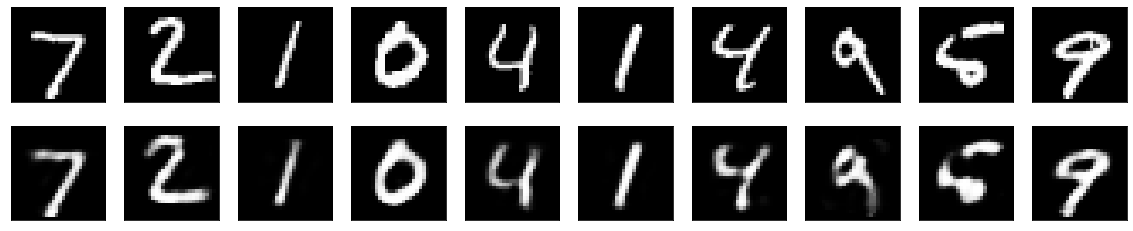

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
